Penny is organizing a party at her apartment, but she is on a tight budget. Having a working knowledge of all of the important things in the universe, Sheldon knows everything about linear programming and offered to help her. He postulates that it’s ideal to have two kinds of mixed nuts: a plain party mix, and a luxury mix (for those with a distinct taste like himself). Based on the expected number of guests, Howard quickly calculates that they’ll need a total of at least 10 pounds of snacks, but no more than 6 pounds of each kind of mix. On his white board, Sheldon has already come up with the following table:

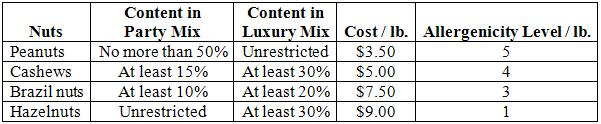

Raj wants to dip the hazelnuts into liquor, but that’s not in the budget, so he gives up. Leonard reminds everyone that, because of their allergies, it’s important to keep the average allergenicity level per pound in both mixes to no more than 3. Write an optimization model to help Penny prepare the two kinds of snacks at minimum cost. But be careful: Sheldon will check it later for correctness!

## a) Problem Formulation and Definitions (REDO)

Constants
- c_p = 3.5
- c_c = 5
- c_b = 7.5
- c_h = 9
- allerg_p = 5
- allerg_c = 4
- allerg_b = 3
- allerg_h = 1

Variables
- amount in party of Peanuts (ap_p)
- amount in party of Cashews (ap_c)
- amount in party of Brazil nuts (ap_b)
- amount in party of Hazlenuts (ap_h)
- amount in luxury of peanuts (al_p)
- amount in luxury of cashews (al_c)
- amount in luxury of brazil nuts (al_b)
- amount in luxury of hazlenuts (al_h)

Objective function:
minimize the sum of the costs: 
- min [(ap_p+al_p) * c_p + (ap_c+al_c) * c_c + (ap_b+al_b) * c_b + (ap_h+al_h) * c_h]

Constraints
- ap_p + ap_c + ap_b + ap_h + al_p + al_c + al_b + al_h ≤ 10

party_mix_constraints
- ap_p + ap_c + ap_b + ap_h ≤ 6
- allerg_p * ap_p + allerg_c * ap_c + allerg_b * ap_b + allerg_h * ap_h / (ap_p + ap_c + ap_b + ap_h) ≤ 3
- ap_p / (ap_p+ap_c+ap_b+ap_h) ≤ 0.5
- ap_c / (ap_p+ap_c+ap_b+ap_h) ≥ 0.15
- ap_b / (ap_p+ap_c+ap_b+ap_h) ≥ 0.1

luxury mix constraints
- al_p + al_c + al_b + al_h ≤ 6
- allerg_p * al_p + allerg_c * al_c + allerg_b * al_b + allerg_h * al_h / (al_p + al_c + al_b + al_h) ≤ 3
- al_c / (al_p+al_c+al_b+al_h) ≥ 0.3
- al_b / (al_p+al_c+al_b+al_h) ≥ 0.2
- al_h / (al_p+al_c+al_b+al_h) ≥ 0.3


In [279]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
opt = SolverFactory("glpk")

model = AbstractModel()

model.nuts = Param(within=NonNegativeIntegers) # Types of nuts (4 in our case)
model.mixes = Param(within=NonNegativeIntegers) # Types of mixes (2 in our case)
model.N = RangeSet(1,model.nuts)
model.M = RangeSet(1,model.mixes)

# Model Parameters
model.cost = Param(model.N,within=NonNegativeReals) # Costs associated with each pound of each type of nuts
model.allergies = Param(model.N,within=NonNegativeIntegers) # Allergy level associated with each type of nuts

# Mixes parameters
model.total_min_amount = Param(within=NonNegativeIntegers) # Total amount of nuts (10 pounds in our case)
model.upper_bounds = Param(model.N,model.M,within=NonNegativeReals) # M = 1 -> Party; M = 2 -> Luxury in our case
model.lower_bounds = Param(model.N,model.M,within=NonNegativeReals)
model.mixes_max_amount = Param(model.M, within=NonNegativeIntegers)
model.mixes_min_amount = Param(model.M, within=NonNegativeIntegers)
model.max_allergy = Param(model.M,within=NonNegativeIntegers)

# Variables of the model
model.x = Var(model.N, model.M)

# Objective Rule
def obj_rule(model):
    return sum(sum(model.x[n,m] for m in model.M)*model.cost[n] for n in model.N)
model.Obj = Objective(rule=obj_rule, sense=minimize)

## Total Amount
def total_amount(model):
    return sum(sum(model.x[n,m] for n in model.N) for m in model.M) >= model.total_min_amount
model.total_amount_constraint = Constraint(rule=total_amount)

## Mixes constraints
# Total mix amount constraint
def low_mix_amount(model, m):
    return model.mixes_min_amount[m] <= sum(model.x[n,m] for n in model.N) 
model.low_mix_amount_constraint = Constraint(model.M, rule = low_mix_amount)

def upper_mix_amount(model, m):
    return sum(model.x[n,m] for n in model.N) <= model.mixes_max_amount[m]
model.up_mix_amount_constrainr = Constraint(model.M, rule = upper_mix_amount)

# Mix upper proportions constraint
def upper_proportion(model, n, m):
    #print(model.lower_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N) <= model.x[n,m] <= model.upper_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N))
    return model.x[n,m] <= model.upper_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N)
model.upper_prop_constraint = Constraint(model.N, model.M, rule = upper_proportion)

# Mix lower proportions constraints
def lower_proportion(model, n, m):
    #print(model.x[n,m] >= model.lower_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N))
    return model.x[n,m] >= model.lower_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N)
model.lower_prop_constraint = Constraint(model.N, model.M, rule = lower_proportion)

# Allergies constraints
def allergies_constr(model, m):
    return sum(model.x[n,m]*model.allergies[n] for n in model.N) <= model.max_allergy[m]*sum(model.x[n0,m] for n0 in model.N)
model.allergies_constraint = Constraint(model.M, rule = allergies_constr)

In [280]:
%%writefile nuts_mixes.dat

param nuts := 4
;

param mixes := 3
;

param cost :=
1 3.5
2 5
3 7.5
4 9
;

param allergies :=
1 5
2 4
3 3
4 1
;

param total_min_amount := 10
;

param upper_bounds :	1	2	3:=
1	0.5	1	1
2	1	1	0.8
3	1	1	0.2
4	1	1	0.5
;

param lower_bounds :	1	2	3:=
1	0	0	0.1
2	0.15	0.3	0
3	0.1	0.2	0
4	0	0.3	0
;

param mixes_max_amount := 
1 6
2 6
3 6
;

param mixes_min_amount :=
1 1
2 1
3 1
;

param max_allergy :=
1 3
2 3
3 3
;

Overwriting nuts_mixes.dat


In [285]:
instance = model.create_instance('nuts_mixes.dat')

instance.dual = Suffix(direction=Suffix.IMPORT)
results = opt.solve(instance, tee=True)

print("PRIMAL")
print(results)

print("DUAL")
instance.dual.pprint()

print()
print("Variable values")
for j in range(3):
    for i in range(4):
        print("Mix", j, "Nut", i, "Amount", instance.x[i+1,j+1].value)
    print()


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmp1xvuom1j.glpk.raw
 --wglp /Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpen4tfj84.glpk.glp
 --cpxlp /Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmp8egpwp8k.pyomo.lp
Reading problem data from '/Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmp8egpwp8k.pyomo.lp'...
35 rows, 13 columns, 116 non-zeros
264 lines were read
Writing problem data to '/Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpen4tfj84.glpk.glp'...
226 lines were written
GLPK Simplex Optimizer, v4.65
35 rows, 13 columns, 116 non-zeros
Preprocessing...
27 rows, 12 columns, 106 non-zeros
Scaling...
 A: min|aij| =  1.000e-01  max|aij| =  2.000e+00  ratio =  2.000e+01
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 27
      0: obj =   0.000000000e+00 inf =   1.300e+01

## b) Sensitivity Analysis

For the sensitivity analysis, we will compute the solution to the problem, i.e. the value of the objective function when one constraint (and only one at a time) changes its value in one unit.

It is important to bear in mind that the we can only carry out the sensitivity analysis for the Total Amount Constraint and the lower and upper mix amount constraints since the rest of the constraints involve proportions and therefore cannot be computed by changing in one unit the column vector b is changed.
The main reason why we cannot obtain sensitivities for proportional constraints is because they do not change the result of the objective function linearly. We can show this by means of an example:

If we take the upper proportion constraint for peanuts in the party mix, which states that at most the amount of peanuts in the party mix cannot be higher than 50% of the total amount of party mix. Mathematically this is:

$$
    \frac{x_{11}}{x_{11}+x_{21}+x_{31}+x_{41}} \leq 0.5
$$

Wich can be restated as follows, being this formulation the one that will be used later to obtain the dual problem's formulation:

$$
    0.5x_{11}-0.5x_{21}-0.5x_{31}-0.5x_{41} \leq 0
$$

In order to prove that this constraint cannot be used for the sensitivity analysis, we will compute the value in two cases, which as a result, if the relation were linear, would have the same sensitivity.
- Case 1

$$
    0.5x_{11}-0.5x_{21}-0.5x_{31}-0.5x_{41} \leq 1
$$

- Case 2

$$
    0.5x_{11}-0.5x_{21}-0.5x_{31}-0.5x_{41} \geq -1
$$

Just by looking as these two statement we can see that they cannot be converted back to a proportional form with physical sense but we will try to obtain the results anyway:
- Case 1

$$
z^{*}= 63.3041666666667; \Delta z^{*} = 0.08541666667; \Delta b = 1
\\
\lambda_{+} = \frac{\Delta z^{*}}{\Delta b} = 0.08541666667
$$

- Case 2

$$
z^{*}= 63.21875; \Delta z^{*} = 0; \Delta b = -1
\\
\lambda_{-} = \frac{\Delta z^{*}}{\Delta b} = 0
$$

$$
    \lambda_{+} ≠ \lambda_{-}
$$

For both of these reasons (not having physical sense and not being linear with the objective function) we will not be computing the sensitivities for these proportional constraints.

#### Results without changes

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 1.0125 	| 0.175  	| 3.0   	|
| **Cashews**     	| 0.45   	| 0.3    	| 0     	|
| **Brazil Nuts** 	| 0.3    	| 0.2    	| 0     	|
| **Hazlenuts**   	| 1.2375 	| 0.325  	| 3.0   	|

$$
z^{*} = 63.21875
$$

### Amount Changes
#### Total minimum amount: 10 -> 11

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 1.35  	| 0.175  	| 3.0   	|
| **Cashews**     	| 0.6   	| 0.3    	| 0     	|
| **Brazil Nuts** 	| 0.4    	| 0.2    	| 0     	|
| **Hazlenuts**   	| 1.65  	| 0.325  	| 3.0   	|

$$
z^{*}= 69.125
\\
\lambda = \frac{\Delta z^{*}}{\Delta b} = 6.3937
$$

- As the total minimum amount is increased, we are forced to buy more of each type of nut. 

#### Party Mix Max Amount: 6 -> 7 (No changes!)

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 1.0125 	| 0.175  	| 3.0   	|
| **Cashews**     	| 0.45   	| 0.3    	| 0     	|
| **Brazil Nuts** 	| 0.3    	| 0.2    	| 0     	|
| **Hazlenuts**   	| 1.2375 	| 0.325  	| 3.0   	|

$$
z^{*}= 63.21875
\\
\lambda = \frac{\Delta z^{*}}{\Delta b} = 0
$$
- There is no change in the objective function because this restriction is not active.

#### Luxury Mix Max Amount 6 -> 7 (No changes!)

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 1.0125 	| 0.175  	| 3.0   	|
| **Cashews**     	| 0.45   	| 0.3    	| 0     	|
| **Brazil Nuts** 	| 0.3    	| 0.2    	| 0     	|
| **Hazlenuts**   	| 1.2375 	| 0.325  	| 3.0   	|

$$
z^{*}= 63.21875
\\
\lambda = \frac{\Delta z^{*}}{\Delta b} = 0
$$
- There is no change in the objective function because this restriction is not active.

#### Type 3 Mix Max Amount 6 -> 7

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 0.675 	| 0.175  	| 3.5   	|
| **Cashews**     	| 0.3   	| 0.3    	| 0     	|
| **Brazil Nuts** 	| 0.2    	| 0.2    	| 0     	|
| **Hazlenuts**   	| 1.825 	| 0.325  	| 3.5   	|

$$
z^{*}= 63.075
\\
\lambda = \frac{\Delta z^{*}}{\Delta b} = -0.14374
$$
- As the Mix Max Amount for type 3 is level up, we are increasing the other-mix type

#### Party Mix Min Amount 1 -> 2 (No changes!)

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 1.0125 	| 0.175  	| 3.0   	|
| **Cashews**     	| 0.45   	| 0.3    	| 0     	|
| **Brazil Nuts** 	| 0.3    	| 0.2    	| 0     	|
| **Hazlenuts**   	| 1.2375 	| 0.325  	| 3.0   	|

$$
z^{*}= 63.21875
\\
\lambda = \frac{\Delta z^{*}}{\Delta b} = 0
$$
- There is no change in the objective function

#### Luxury Mix Min Amount 1 -> 2

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 0.675 	| 0.35  	| 3.0   	|
| **Cashews**     	| 0.3   	| 0.6    	| 0     	|
| **Brazil Nuts** 	| 0.2    	| 0.4    	| 0     	|
| **Hazlenuts**   	| 0.825 	| 0.65  	| 3.0   	|

$$
z^{*}= 63.3625
\\
\lambda = \frac{\Delta z^{*}}{\Delta b} = 0.14374
$$
- Bla bla

#### Type 3 Mix Min Amount 1 -> 2 (No changes!)

| Nut              	| Party  	| Luxury 	| Other 	|
|-----------------	|--------	|--------	|-------	|
| **Peanuts**     	| 1.0125 	| 0.175  	| 3.0   	|
| **Cashews**     	| 0.45   	| 0.3    	| 0     	|
| **Brazil Nuts** 	| 0.3    	| 0.2    	| 0     	|
| **Hazlenuts**   	| 1.2375 	| 0.325  	| 3.0   	|

$$
z^{*}= 63.21875
\\
\lambda = \frac{\Delta z^{*}}{\Delta b} = 0
$$
- There is no change in the objective function


## c) Duality

In order to obtain the dual problem we first have to formulate our problem in General Form, which looks as follows:

<li><font color="blue">Primal:</font>
    $$
        \begin{array}{ll}
            min\ z_{P} = c^{T} x
        \\
            s.t
        \\
            \ \ \ Ax \geq b
        \\
            \ \ \ x \geq 0
        \end{array}
    $$

Being the dual problem the following one, expressed as well in General Form:

<li><font color="blue">Dual:</font>
    $$
        \begin{array}{ll}
            max\ z_{D} = b^{T} y
        \\
            s.t
        \\
            \ \ \ A^{T}y \leq c
        \\
            \ \ \ y \geq 0
        \end{array} 
    $$

From the formultation used in the description of the problem, we have to obtain the expanded equations for each constraint so that we can construct the matrix A. This equations look as follows:

<li><font color="blue">Total amount constraint:</font>
    $$
        \text{Original Formulation}
        \\
        \sum_{i=1}^{N=4} \sum_{j=1}^{M=3} x_{ij} \geq 10
        \\
    $$
<p>   
    $$
        \\
        \text{Extended Formulation}
        \\
        x_{11}+x_{12}+x_{13}+x_{21}+x_{22}+x_{23}+x_{31}+x_{32}+x_{33}+x_{41}+x_{42}+x_{43} \geq 10
    $$
    
<li><font color="blue">Mix amount constraints:</font>
    $$
        \text{Original Formulation}
        \\
        1 \leq \sum_{i=1}^{N=4} x_{ij} \leq 6, \ \forall j = 1,2,3
        \\
    $$
<p>
    $$
        \\
        \text{Extended Formulation}
        \\
        x_{11}+x_{21}+x_{31}+x_{41} \geq 1
        \\
        -x_{11}-x_{21}-x_{31}-x_{41} \geq -6
        \\
        x_{12}+x_{22}+x_{32}+x_{42} \geq 1
        \\
        -x_{12}-x_{22}-x_{32}-x_{42} \geq -6
        \\
        x_{13}+x_{23}+x_{33}+x_{43} \geq 1
        \\
        -x_{13}-x_{23}-x_{33}-x_{43} \geq -6
        \\
    $$
    
<li><font color="blue">Proportion constraints:</font>
    $$
        \text{Original Formulation}
        \\
        L_{j} \leq \frac{1}{\sum_{i=1}^{N=4}x_{ij}} X_j \leq U_{j}, \ \forall j = 1,2,3
        \\
        \text{Where:}
        \\
        L=\begin{bmatrix}
            0 & 0 & 0.1 \\
            0.15 & 0.3 & 0 \\
            0.1 & 0.2 & 0 \\
            0 & 0.3 & 0
          \end{bmatrix}, 
          X=\begin{bmatrix}
            x_{11} & x_{12} & x_{13} \\
            x_{21} & x_{22} & x_{23} \\
            x_{31} & x_{32} & x_{33} \\
            x_{41} & x_{42} & x_{43}
          \end{bmatrix}, \text{and }
          U=\begin{bmatrix}
            0.5 & 1 & 1 \\
            1 & 1 & 0.8 \\
            1 & 1 & 0.2 \\
            1 & 1 & 0.5
          \end{bmatrix}
        \\
    $$
<p>
    $$
        \\
        \text{Extended Formulation}
        \\
        -0.5x_{11}+0.5x_{21}+0.5x_{31}+0.5x_{41} \geq 0
        \\
        x_{11}+x_{31}+x_{41} \geq 0
        \\
        x_{11}+x_{21}+x_{41} \geq 0
        \\
        x_{11}+x_{21}+x_{31} \geq 0
        \\
        x_{11} \geq 0
        \\
        -0.15x_{11}+0.85x_{21}-0.15x_{31}-0.15x_{41} \geq 0
        \\
        -0.1x_{11}-0.1x_{21}+0.9x_{31}-0.1x_{41} \geq 0
        \\
        x_{41} \geq 0
        \\
        x_{22}+x_{32}+x_{42} \geq 0
        \\
        x_{12}+x_{32}+x_{42} \geq 0
        \\
        x_{12}+x_{22}+x_{42} \geq 0
        \\
        x_{12}+x_{22}+x_{32} \geq 0
        \\
        x_{12} \geq 0
        \\
        -0.3x_{12}+0.7x_{22}-0.3x_{32}-0.3x_{42} \geq 0
        \\
        -0.2x_{12}-0.2x_{22}+0.8x_{32}-0.2x_{42} \geq 0
        \\
        -0.3x_{12}-0.3x_{22}-0.3x_{32}+0.7x_{42} \geq 0
        \\
        x_{23}+x_{33}+x_{43} \geq 0
        \\
        0.8x_{13}-0.2x_{23}+0.8x_{33}+0.8x_{43} \geq 0
        \\
        0.2x_{13}+0.2x_{23}-0.8x_{33}+0.2x_{43} \geq 0
        \\
        0.5x_{13}+0.5x_{23}+0.5x_{33}-0.5x_{43} \geq 0
        \\
        0.9x_{13}-0.1x_{23}-0.1x_{33}-0.1x_{43} \geq 0
        \\
        x_{23} \geq 0
        \\
        x_{33} \geq 0
        \\
        x_{43} \geq 0
        \\
    $$

<li><font color="blue">Maximum levels of allergy per mix:</font>
    $$
        \text{Original Formulation}
        \\
        \frac{1}{\sum_{i=1}^{N=4} x_{ij}} \sum_{i=1}^{N=4} x_{ij}h_{i} \leq H_{j}, \ \forall j = 1,2,3
        \\
    $$
<p>
    $$
        \\
        \text{Extended Formulation}
        \\
        -2x_{11}-x_{21}+2x_{41} \geq 0
        \\
        -2x_{12}-x_{22}+2x_{42} \geq 0
        \\
        -2x_{13}-x_{23}+2x_{43} \geq 0
    $$
    
    
Now obtaining in order to obtain the model parameters what we need to do is:
<li><font color = "blue">For A matrix use all the equation coefficients:</font>
$$
    \\
    A=\begin{bmatrix}
            1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
            -1 & 0 & 0 & -1 & 0 & 0 & -1 & 0 & 0 & -1 & 0 & 0 \\
            1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 \\
            0 & -1 & 0 & 0 & -1 & 0 & 0 & -1 & 0 & 0 & -1 & 0 \\
            0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 \\
            0 & 0 & -1 & 0 & 0 & -1 & 0 & 0 & -1 & 0 & 0 & -1 \\
            0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 \\
            -0.5 & 0 & 0 & 0.5 & 0 & 0 & 0.5 & 0 & 0 & 0.5 & 0 & 0 \\
            1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0\\
            1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
            1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
            1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
            -0.15 & 0 & 0 & 0.85 & 0 & 0 & -0.15 & 0 & 0 & -0.15 & 0 & 0\\ 
            -0.1 & 0 & 0 & -0.1 & 0 & 0 & 0.9 & 0 & 0 & -0.1 & 0 & 0 \\
            0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
            0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0\\
            0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0\\
            0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
            0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
            0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
            0 & -0.3 & 0 & 0 & 0.7 & 0 & 0 & -0.3 & 0 & 0 & -0.3 & 0 \\
            0 & -0.2 & 0 & 0 & -0.2 & 0 & 0 & 0.8 & 0 & 0 & -0.2 & 0 \\
            0 & -0.3 & 0 & 0 & -0.3 & 0 & 0 & -0.3 & 0 & 0 & 0.7 & 0 \\
            0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 \\
            0 & 0 & 0.8 & 0 & 0 & -0.2 & 0 & 0 & 0.8 & 0 & 0 & 0.8 \\
            0 & 0 & 0.2 & 0 & 0 & 0.2 & 0 & 0 & -0.8 & 0 & 0 & 0.2 \\
            0 & 0 & 0.5 & 0 & 0 & 0.5 & 0 & 0 & 0.5 & 0 & 0 & -0.5 \\
            0 & 0 & 0.9 & 0 & 0 & -0.1 & 0 & 0 & -0.1 & 0 & 0 & -0.1 \\
            0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
            0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
            0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
            -2 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 \\
            0 & -2 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 2 & 0 \\
            0 & 0 & -2 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 2
          \end{bmatrix}
     \\
$$
<p>
<li><font color = "blue">The b column vector is just the right hand side of the equations:</font>
$$
    b=\begin{bmatrix}
            10\\
            -6\\
            1\\
            -6\\
            1\\
            -6\\
            1\\
            0\\
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0\\  
            0
          \end{bmatrix}
     \\
$$

<li><font color = "blue">And the cost vector looks as follows:</font>
$$
    c=\begin{bmatrix}
            3.5\\ 
            3.5\\ 
            3.5\\ 
            5\\
            5\\  
            5\\  
            7.5\\ 
            7.5\\ 
            7.5\\ 
            9\\  
            9\\  
            9
         \end{bmatrix}
$$
    
    
Now that we have all the parameters for the model, we can formulate the Dual problem according to the formulation we have shown previously in which the **Objective Function** looks as follows:
$$
    max\ z_{D} = b^{T} y
$$
and the **Constraints** are:
$$
    \\
    s.t. \ A^{T}y \leq c
    \\
    \ \ y \geq 0
$$

If we input the data we have obtained according to the parameters, the objective function would be:
$$
    max \sum_{i=1}^{20} b_{i}y_{i} = 10y_1-6y_2+y_3-6y_4+y_5-6y_6+y_7
$$
and the constraints:
$$
    \\
    \ \ \ \ s.t. y_1-y_2+y_3-0.5y_8-0.15y_9-0.1y_{10}-2y_{18} \leq 3.5
    \\
    \ \ \ \ \ \ \ \ \ \ \ y_1-y_4+y_5-0.3y_{11}-0.2y_{12}-0.3y_{13}-2y_{19} \leq 3.5
    \\
    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ y_1-y_6+y_7+0.9y_{14}+0.8y_{15}+0.2y_{16}+0.5y_{17}-2y_{20} \leq 3.5
    \\
    \ \ \ \ \ y_1-y_2+y_3+0.5y_8+0.85y_9-0.1y_{10}-y_{18} \leq 5
    \\
    \ \ \ \ \ \ y_1-y_4+y_5+0.7y_{11}-0.2y_{12}-0.3y_{13}-y_{19} \leq 5
    \\
    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ y_1-y_6+y_7-0.1y_{14}-0.2y_{15}+0.2y_{16}+0.5y_{17}-y_{20} \leq 5
    \\
    y_1-y_2+y_3+0.5y_8-0.15y_9+0.9y_{10} \leq 7.5
    \\
    y_1-y_4+y_5-0.3y_{11}+0.8y_{12}-0.3y_{13} \leq 7.5
    \\
    \ \ \ \ \ \ \ \ \ \ \ \ \ \ y_1-y_6+y_7-0.1y_{14}+0.8y_{15}-0.8y_{16}+0.5y_{17} \leq 7.5
    \\
    \ \ \ \ \ \ y_1-y_2+y_3+0.5y_8-0.15y_9-0.1y_{10}+2y_{18} \leq 9
    \\
    \ \ \ \ \ \ y_1-y_4+y_5-0.3y_{11}-0.2y_{12}+0.7y_{13}+2y_{19} \leq 9
    \\
    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ y_1-y_6+y_7-0.1y_{14}+0.8y_{15}+0.2y_{16}-0.5y_{17}+2y_{20} \leq 9
    \\
$$

With this, we have now all the equations needed to solve the Dual problem as we are going to do below.

In [311]:
## Data for the dual problem
# Total amount constraint (CHECK SENSITIVITY)
row1=np.array([1,1,1,1,1,1,1,1,1,1,1,1])
# Upper boundary for party mix (CHECK SENSITIVITY)
row2=np.array([-1,0,0,-1,0,0,-1,0,0,-1,0,0])
# Lower boundary for party mix (CHECK SENSITIVITY)
row3=-np.array([-1,0,0,-1,0,0,-1,0,0,-1,0,0])
# Upper boundary for luxury mix (CHECK SENSITIVITY)
row4=np.array([0,-1,0,0,-1,0,0,-1,0,0,-1,0])
# Lower boundary for luxury mix (CHECK SENSITIVITY)
row5=-np.array([0,-1,0,0,-1,0,0,-1,0,0,-1,0])
# Upper boundary for other mix (CHECK SENSITIVITY)
row6=np.array([0,0,-1,0,0,-1,0,0,-1,0,0,-1])
# Lower boundary for other mix (CHECK SENSITIVITY)
row7=-np.array([0,0,-1,0,0,-1,0,0,-1,0,0,-1])
# Maximum proportion of peanuts in party mix
row8=np.array([-0.5,0,0,0.5,0,0,0.5,0,0,0.5,0,0])
# Maximum proportion of cashews in party mix
row9 = np.array([1,0,0,0,0,0,1,0,0,1,0,0])
# Maximum proportion of Brazil Nuts in party mix
row10 = np.array([1,0,0,1,0,0,0,0,0,1,0,0])
# Maximum proportion of Hazlenuts in party mix
row11 = np.array([1,0,0,1,0,0,1,0,0,0,0,0])
# Minimum proportion of peanuts in party mix
row12 = np.array([1,0,0,0,0,0,0,0,0,0,0,0])
# Minimum proportion of cashews in party mix
row13=np.array([-0.15,0,0,0.85,0,0,-0.15,0,0,-0.15,0,0])
# Minimum proportion of Brazil nuts in party mix
row14=np.array([-0.1,0,0,-0.1,0,0,0.9,0,0,-0.1,0,0])
# Minimum proportion of hazlenuts in party mix
row15 = np.array([0,0,0,0,0,0,0,0,0,1,0,0])
# Maximum proportion of peanuts in luxury mix
row16 = np.array([0,0,0,0,1,0,0,1,0,0,1,0])
# Maximum proportion of cashews in luxury mix
row17 = np.array([0,1,0,0,0,0,0,1,0,0,1,0])
# Maximum proportion of brazil nuts in luxury mix
row18 = np.array([0,1,0,0,1,0,0,0,0,0,1,0])
# Maximum proportion of hazlenuts in luxury mix
row19 = np.array([0,1,0,0,1,0,0,1,0,0,0,0])
# Minimum proportion of peanuts in luxury mix
row20 = np.array([0,1,0,0,0,0,0,0,0,0,0,0])
# Minimum proportion of cashews in luxury mix
row21=np.array([0, -0.3, 0, 0, 0.7, 0, 0, -0.3, 0, 0, -0.3,0])
# Minimum proportion of Brazil nuts in luxury mix
row22=np.array([0, -0.2, 0, 0, -0.2, 0, 0, 0.8, 0, 0, -0.2, 0])
# Minimum proportion of hazlenuts in luxury mix
row23=np.array([0, -0.3, 0, 0, -0.3, 0, 0, -0.3, 0, 0, 0.7, 0])
# Maximum proportion of peanuts in other mix
row24=np.array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1])
# Maximum proportion of cashews in other mix
row25=np.array([0, 0, 0.8, 0, 0, -0.2, 0, 0, 0.8, 0, 0, 0.8])
# Maximum proportion of Brazil nuts in other mix
row26=np.array([0, 0, 0.2, 0, 0, 0.2, 0, 0, -0.8, 0, 0, 0.2])
# Maximum proportion of hazlenuts in other mix
row27=np.array([0, 0, 0.5, 0, 0, 0.5, 0, 0, 0.5, 0, 0, -0.5])
# Minimum proportion of peanuts in other mix
row28=np.array([0, 0, 0.9, 0, 0, -0.1, 0, 0, -0.1, 0, 0, -0.1])
# Minimum proportion of cashews in other mix
row29=np.array([0,0,0,0,0,1,0,0,0,0,0,0])
# Minimum proportion of brazil nuts in other mix
row30=np.array([0,0,0,0,0,0,0,0,1,0,0,0])
# Minimum proportion of hazlenuts in other mix
row31=np.array([0,0,0,0,0,0,0,0,0,0,0,1])
# Maximum level of allergy for party, luxury and other mixes respectively
row32=np.array([-2, 0, 0, -1, 0, 0, 0, 0, 0, 2, 0, 0])
row33=np.array([0, -2, 0, 0, -1, 0, 0, 0, 0, 0, 2, 0])
row34=np.array([0, 0, -2, 0, 0, -1, 0, 0, 0, 0, 0, 2])

A=np.matrix(data=(row1,row2,row3,row4,row5,row6,row7,row8,row9,row10,row11,row12,row13,row14,row15,row16,row17,row18,row19,row20,row21,row22,row23,row24,row25,row26,row27,row28,row29,row30,row31,row32,row33,row34))
b=np.array([10,-6,1,-6,1,-6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
c=np.array([3.5,3.5,3.5,5,5,5,7.5,7.5,7.5,9,9,9])

################### PRIMAL Model stated with general formulation ###################
primalModel = AbstractModel()

primalModel.I = RangeSet(1,len(c)) # Amount of variables
primalModel.J = RangeSet(1,len(A)) # Amount of constraints
primalModel.x = Var(primalModel.I, domain=NonNegativeReals)

def primal_objective(primalModel):
    return sum(primalModel.x[i]*c[i-1] for i in primalModel.I)
primalModel.Obj = Objective(rule=primal_objective, sense=minimize)

def primal_constraints(primalModel, j):
    return sum(primalModel.x[i]*A[j-1,i-1] for i in primalModel.I) >= b[j-1]
primalModel.Constraints = Constraint(primalModel.J, rule = primal_constraints)

primalInstance = primalModel.create_instance()
primalResults = opt.solve(primalInstance)
print("PRIMAL")
print(primalResults)

lambdas = np.zeros(len(A))
explain = ["Total amount constraint", "Upper boundary for party mix", "Lower boundary for party mix", "Upper boundary for luxury mix", "Lower boundary for luxury mix", "Upper boundary for other mix", "Lower boundary for other mix"]
original_objective = np.float(primalInstance.Obj())
print(original_objective)
b = np.array([10,-6,1,-6,1,-6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
for i in range(len(b)):
    b[i] += -1
    sensitivityInstance = primalModel.create_instance()
    sensitivityResults = opt.solve(sensitivityInstance)
    if (i < 7):
        print("Explanation", explain[i])
        print("Original Objective: ", original_objective)
        print("New Objective: ", np.float(sensitivityInstance.Obj()))
        print("Sensitivity: ", original_objective-np.float(sensitivityInstance.Obj()))
        print()
    lambdas[i] = original_objective-np.float(sensitivityInstance.Obj())
    b = np.array([10,-6,1,-6,1,-6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    
################### DUAL Model stated with general formulation ###################
dualModel = AbstractModel()

dualModel.I = RangeSet(1,len(A)) # Amount of variables
dualModel.J = RangeSet(1,len(c)) # Amount of constraints
dualModel.y = Var(dualModel.I, domain=NonNegativeReals)

def dual_objective(dualModel):
    return sum(dualModel.y[i]*b[i-1] for i in dualModel.I)
dualModel.Obj = Objective(rule=dual_objective, sense=maximize)

def dual_constraints(dualModel, j):
    return sum(dualModel.y[i]*A[i-1,j-1] for i in dualModel.I) <= c[j-1]
dualModel.Constraints = Constraint(dualModel.J, rule = dual_constraints)

dualInstance = dualModel.create_instance()
dualResults = opt.solve(dualInstance)

print()
print("DUAL")
print(dualResults)
index = [0,1,2,3,4,5,6]
explain = ["Total amount constraint", "Upper boundary for party mix", "Lower boundary for party mix", "Upper boundary for luxury mix", "Lower boundary for luxury mix", "Upper boundary for other mix", "Lower boundary for other mix"]
for i in index:
    print("Explaination", explain[i], "Amount", dualInstance.y[i+1].value)
    print()
    
## As we can see from both outputs the result of the objective function in the optimal point are the same.
## Therefore the String Duality Theorem is met.
    

PRIMAL

Problem: 
- Name: unknown
  Lower bound: 63.21875
  Upper bound: 63.21875
  Number of objectives: 1
  Number of constraints: 35
  Number of variables: 13
  Number of nonzeros: 116
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0215151309967041
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

63.21875
Explanation Total amount constraint
Original Objective:  63.21875
New Objective:  56.825
Sensitivity:  6.393749999999997

Explanation Upper boundary for party mix
Original Objective:  63.21875
New Objective:  63.21875
Sensitivity:  0.0

Explanation Lower boundary for party mix
Original Objective:  63.21875
New Objective:  63.21875
Sensitivity:  0.0

Explanation Upper boundary for luxury mix
Original Objective:  63.21875
New Objective:  63.21875
Sensitivity:  0.0

Explanation Lower boundary for lu

## d) Problem Modification

In order to reformulate our problem as a Mixed Integer Problem, we have decided to add a constraint wich is the following: at most each type of nut can only belong to 2 mixes. This constrint can be understood as ensuring than the mixes are different enough. Mathematically it looks as follows:

$$
y_{ij}=
\left\{\begin{array}{ll} 
1, & \text{if nut $i$ belongs in mix $j$,}\\
0, & \text{if nut $i$ does not belong in mix $j$}
\end{array} \right.\quad \forall i=1,2,3,4 \quad \forall j=1,2,3
\\
\sum_{j=1}^{J=3} y_{ij} \leq 2 \ \forall i=1,2,3,4
$$

With this we have added a new constraint that ensures variety of the mixes, but we also have to ensure that if $y_{ij} = 1$ then $x_{ij} ≠ 0$ and if $y_{ij} = 0$ then $x_{ij} = 0$. In order to met these critiria we have to add another constraint.

$$
x_{ij} - My_{ij} \leq 0, \ \forall i=1,2,3,4 \text{ and where $M$ is a large enough value}
$$

Also, we need to change thw objective function so that the sum of all $y_{ij}$ is minimized. With this, the formulation of the new problem looks as follows:

<li><font color="blue">Variables: </font>
    $$
    x_{ij} \in \mathbb{R} \text{ and } x_{ij} \geq 0
    \\
    y_{ij}=\left\{\begin{array}{ll} 
    1, & \text{if nut $i$ belongs in mix $j$,}\\
    0, & \text{if nut $i$ does not belong in mix $j$}
    \end{array} \right.\quad \forall i=1,2,3,4 \quad \forall j=1,2,3
    $$

<li><font color="blue">Objective Function: </font>
    $$
        min \sum_{i=1}^{I=4} \left( c_{i}\sum_{j=1}^{J=3} x_{ij} \right) + \sum_{i=1}^{I=4}\sum_{j=1}^{J=3} y_{ij}
    $$

<li><font color="blue">Total amount constraints: </font>
    $$
        \sum_{j=1}^{M=3}\sum_{i=1}^{I=4} x_{ij} \geq 10
    $$

<li><font color="blue">Mix amount constraints: </font>
    $$
        1 \leq \sum_{i=1}^{I=4} x_{ij} \leq 6, \ \forall j = 1,2,3
    $$

<li><font color="blue">Proportion constraints: </font>
    $$
     L_{j} \leq \frac{1}{\sum_{i=1}^{I=4}x_{ij}} X_j \leq U_{j}, \ \forall j = 1,2,3
        \\
        \text{Where:}
        \\
        L=\begin{bmatrix}
            0 & 0 & 0.1 \\
            0.15 & 0.3 & 0 \\
            0.1 & 0.2 & 0 \\
            0 & 0.3 & 0
          \end{bmatrix}, 
          X=\begin{bmatrix}
            x_{11} & x_{12} & x_{13} \\
            x_{21} & x_{22} & x_{23} \\
            x_{31} & x_{32} & x_{33} \\
            x_{41} & x_{42} & x_{43}
          \end{bmatrix}, \text{and }
          U=\begin{bmatrix}
            0.5 & 1 & 1 \\
            1 & 1 & 0.8 \\
            1 & 1 & 0.2 \\
            1 & 1 & 0.5
          \end{bmatrix}
        \\
    $$
    
<li><font color="blue">Maximum levels of allergy per mix constraints: </font>
    $$
        \\
        \frac{1}{\sum_{i=1}^{I=4} x_{ij}} \sum_{i=1}^{J=4} x_{ij}h_{i} \leq H_{j}, \ \forall j = 1,2,3
        \\
    $$
    
<li><font color="blue">Variety constraints: </font>
    $$
        \sum_{j=1}^{J=3} y_{ij} \leq 2, \ \forall i=1,2,3,4
    $$
    
<li><font color="blue">Ensurance constraints: </font>
    $$
        x_{ij} - My_{ij} \leq 0, \ \forall i=1,2,3,4 \text{ and where $M$ is a large enough value}
    $$

In [393]:
opt = SolverFactory("glpk")

newModel = AbstractModel()

newModel.nuts = Param(within=NonNegativeIntegers) # Types of nuts (4 in our case)
newModel.mixes = Param(within=NonNegativeIntegers) # Types of mixes (2 in our case)
newModel.I = RangeSet(1,newModel.nuts)
newModel.J = RangeSet(1,newModel.mixes)

# Model Parameters
newModel.cost = Param(newModel.I,within=NonNegativeReals) # Costs associated with each pound of each type of nuts
newModel.allergies = Param(newModel.I,within=NonNegativeIntegers) # Allergy level associated with each type of nuts
newModel.variety = Param(newModel.I,within=NonNegativeIntegers)

# Mixes parameters
newModel.total_min_amount = Param(within=NonNegativeIntegers) # Total amount of nuts (10 pounds in our case)
newModel.upper_bounds = Param(newModel.I,newModel.J,within=NonNegativeReals) # M = 1 -> Party; M = 2 -> Luxury in our case
newModel.lower_bounds = Param(newModel.I,newModel.J,within=NonNegativeReals)
newModel.mixes_max_amount = Param(newModel.J, within=NonNegativeIntegers)
newModel.mixes_min_amount = Param(newModel.J, within=NonNegativeIntegers)
newModel.max_allergy = Param(newModel.J,within=NonNegativeIntegers)

# Variables of the model
newModel.x = Var(newModel.I, newModel.J)
newModel.y = Var(newModel.I, newModel.J, domain=Binary)

# Objective Rule
def obj_rule(newModel):
    return sum(sum(newModel.x[i,j] for j in newModel.J)*newModel.cost[i] for i in newModel.I) + sum(sum(newModel.y[i,j] for i in newModel.I) for j in newModel.J)
newModel.Obj = Objective(rule=obj_rule, sense=minimize)

## Total Amount
def total_amount(newModel):
    return sum(sum(newModel.x[i,j] for i in newModel.I) for j in newModel.J) >= newModel.total_min_amount
newModel.total_amount_constraint = Constraint(rule=total_amount)

## Mixes constraints
# Total mix amount constraint
def low_mix_amount(newModel, j):
    return newModel.mixes_min_amount[j] <= sum(newModel.x[i,j] for i in newModel.I) 
newModel.low_mix_amount_constraint = Constraint(newModel.J, rule = low_mix_amount)

def upper_mix_amount(newModel, j):
    return sum(newModel.x[i,j] for i in newModel.I) <= newModel.mixes_max_amount[j]
newModel.up_mix_amount_constrainr = Constraint(newModel.J, rule = upper_mix_amount)

# Mix upper proportions constraint
def upper_proportion(newModel, i, j):
    #print(model.lower_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N) <= model.x[n,m] <= model.upper_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N))
    return newModel.x[i,j] <= newModel.upper_bounds[i,j]*sum(newModel.x[i0,j] for i0 in newModel.I)
newModel.upper_prop_constraint = Constraint(newModel.I, newModel.J, rule = upper_proportion)

# Mix lower proportions constraints
def lower_proportion(newModel, i, j):
    #print(model.x[n,m] >= model.lower_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N))
    return newModel.x[i,j] >= newModel.lower_bounds[i,j]*sum(newModel.x[i0,j] for i0 in newModel.I)
newModel.lower_prop_constraint = Constraint(newModel.I, newModel.J, rule = lower_proportion)

# Allergies constraints
def allergies_constr(newModel, j):
    return sum(newModel.x[i,j]*newModel.allergies[i] for i in newModel.I) <= newModel.max_allergy[j]*sum(newModel.x[i0,j] for i0 in newModel.I)
newModel.allergies_constraint = Constraint(newModel.J, rule = allergies_constr)

# Variety constriants
def variety_constr(newModel, i):
    return sum(newModel.y[i,j] for j in newModel.J) <= newModel.variety[i]
newModel.variety_constraint = Constraint(newModel.I, rule = variety_constr)

# Constriant to ensure that x[i,j] is equal to 0 when y[i,j] is equal to 0 and x[i,j] is higher than 0 when y[i,j] is equal to 1
def ensure_constr(newModel, i, j):
    return newModel.x[i,j] - 1000*newModel.y[i,j] <= 0
newModel.ensure = Constraint(newModel.I, newModel.J, rule=ensure_constr)

In [398]:
%%writefile new_nuts_mixes.dat

param nuts := 4
;

param mixes := 3
;

param variety := 
1 2
2 2
3 2
4 3
;

param cost :=
1 3.5
2 5
3 7.5
4 9
;

param allergies :=
1 5
2 4
3 3
4 1
;

param total_min_amount := 10
;

param upper_bounds :	1	2	3:=
1	0.5	1	1
2	1	1	0.8
3	1	1	0.2
4	1	1	0.5
;

param lower_bounds :	1	2	3:=
1	0	0	0.1
2	0.15	0.3	0
3	0.1	0.2	0
4	0	0.3	0
;

param mixes_max_amount := 
1 6
2 6
3 6
;

param mixes_min_amount :=
1 1
2 1
3 1
;

param max_allergy :=
1 3
2 3
3 3
;

Overwriting new_nuts_mixes.dat


In [399]:
newInstance = newModel.create_instance('new_nuts_mixes.dat')

newInstance.dual = Suffix(direction=Suffix.IMPORT)
newResults = opt.solve(newInstance, tee=True)

print("PRIMAL")
print(newResults)

print("DUAL")
newInstance.dual.pprint()

print()
print("Variable values")
for j in range(3):
    for i in range(4):
        print("Mix", j, "Nut", i, "Amount", newInstance.x[i+1,j+1].value)
        print("Mix", j, "Nut", i, "Amount (BINARY)", newInstance.y[i+1,j+1].value)
    print()


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpz8jv82cl.glpk.raw
 --wglp /Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmp0wjuwr4f.glpk.glp
 --cpxlp /Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpsflmqpfh.pyomo.lp
Reading problem data from '/Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpsflmqpfh.pyomo.lp'...
/Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpsflmqpfh.pyomo.lp:373: warning: lower bound of variable 'x13' redefined
/Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpsflmqpfh.pyomo.lp:373: warning: upper bound of variable 'x13' redefined
51 rows, 25 columns, 152 non-zeros
12 integer variables, all of which are binary
385 lines were read
Writing problem data to '/Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmp0wjuwr4f.glpk.glp'...
319 lines were written
GLPK Integer Optimizer,